# `method` on zf

# running `method` on zf

## imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scanpy -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 7.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sys
import importlib

In [4]:
filehandle_wdm = 'drive/Othercomputers/numac/GitHub/WDM/'
filehandle_save = 'drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save/'
filehandle_zf = 'drive/MyDrive/DX/_data/zebrafish/cleaned_common_pca/'

sys.path.insert(0, filehandle_wdm)
sys.path.insert(0, filehandle_save)
sys.path.insert(0, filehandle_zf)

import clustering
import util_LR
import util_zf
import FRLC_LRDist

## reload

In [5]:
importlib.reload(clustering)
importlib.reload(util_LR)
importlib.reload(util_zf)
importlib.reload(FRLC_LRDist)

<module 'FRLC_LRDist' from '/content/drive/Othercomputers/numac/GitHub/WDM/FRLC_LRDist.py'>

## device

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64

On device: cuda


## load zf: spatial, annotation hard clusterings as $Q$'s

In [7]:
# daniocell_dir = '/scratch/gpfs/ph3641/zebrafish/daniocell.h5ad'
# adata_daniocell = sc.read_h5ad(daniocell_dir)
# stages = np.unique(adata_daniocell.obs['hpf'].values)

zf_list = ['zf3', 'zf5', 'zf10', 'zf12', 'zf18', 'zf24']
zf_names = zf_list
filehandles_zf = [filehandle_zf + 'pair' + str(k) + '/' for k in range(len(zf_list))]
N = len(filehandles_zf)

spatial_list = []
exclude_rows = [None, None, None, None, None, None] # [1099, None, None, 325, None, None]

for i in range(len(zf_list)):
    file_spatial = filehandles_zf[i] + zf_names[i] +'_spatial.npy'
    if i == len(zf_list) - 1:
        file_spatial = filehandles_zf[i-1] + zf_names[i] +'_spatial.npy'
    spatial = np.load(file_spatial)
    nidx = exclude_rows[i]
    if nidx is not None:
        spatial = np.concatenate((spatial[:nidx,:], spatial[nidx+1:,:]))
    spatial_list.append(spatial)

In [8]:
''' # Hirak magic
adata = sc.read_h5ad('zf3_stereoseq.h5ad')
adata.X = adata.layers['counts']
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
adata.obs.seurat_clusters = pd.Categorical(adata.obs.seurat_clusters)
sc.tl.rank_genes_groups(adata, groupby="seurat_clusters", method="wilcoxon")
sc.pp.highly_variable_genes(adata, n_top_genes=5000)
adata = adata[:, adata.var.highly_variable ].copy()
final_sc_df = sc.get.rank_genes_groups_df(adata, group=None)
top_genes = final_sc_df.sort_values(by=["logfoldchanges", "pvals"], ascending=[False, True]).head(300)
'''

' # Hirak magic\nadata = sc.read_h5ad(\'zf3_stereoseq.h5ad\')\nadata.X = adata.layers[\'counts\']\n# Normalizing to median total counts\nsc.pp.normalize_total(adata)\n# Logarithmize the data\nsc.pp.log1p(adata)\nadata.obs.seurat_clusters = pd.Categorical(adata.obs.seurat_clusters)\nsc.tl.rank_genes_groups(adata, groupby="seurat_clusters", method="wilcoxon")\nsc.pp.highly_variable_genes(adata, n_top_genes=5000)\nadata = adata[:, adata.var.highly_variable ].copy()\nfinal_sc_df = sc.get.rank_genes_groups_df(adata, group=None)\ntop_genes = final_sc_df.sort_values(by=["logfoldchanges", "pvals"], ascending=[False, True]).head(300)\n'

In [9]:
def intersect(lst1, lst2):
    """
    param: lst1 - list
    param: lst2 - list
    return: list of common elements
    """
    temp = set(lst2)
    lst3 = [value for value in lst1 if value in temp]
    return lst3

def load_mats_2(save_dir, s1_name, s2_name, device, idx, z=100, c=100, nidx_1=None, nidx_2=None):
    # Load costs
    A = np.load(save_dir + 'SA.npy')
    B = np.load(save_dir + 'SB.npy')
    ys, ys2 = get_annotation_markers(idx, filehandle_zf='/scratch/gpfs/ph3641/zebrafish/')
    ys, ys2 = torch.tensor(ys).type(torch.DoubleTensor).to(device), torch.tensor(ys2).type(torch.DoubleTensor).to(device)
    if nidx_1 is not None:
        ys = torch.cat((ys[:nidx_1,:], ys[nidx_1+1:,:]))
    if nidx_2 is not None:
        ys2 = torch.cat((ys2[:nidx_2,:], ys2[nidx_2+1:,:]))
    C = torch.cdist(ys, ys2).type(torch.DoubleTensor).to(device)
    norm1 = c
    norm2 = A.max()*c
    norm3 = B.max()*c
    # Distance matrix factored using SVD
    u, s, v = torch.svd(C)
    print('C done')
    V_C,U_C = torch.mm(u[:,:z], torch.diag(s[:z])), v[:,:z].mT
    u, s, v = torch.svd(torch.from_numpy(A).to(device))
    print('A done')
    V1_A,V1_B = torch.mm(u[:,:z], torch.diag(s[:z])), v[:,:z].mT
    u, s, v = torch.svd(torch.from_numpy(B).to(device))
    print('B done')
    V2_A,V2_B = torch.mm(u[:,:z], torch.diag(s[:z])), v[:,:z].mT
    C_factors, A_factors, B_factors = ((V_C.type(torch.DoubleTensor).to(device)/norm1, U_C.type(torch.DoubleTensor).to(device)/norm1), \
                                   (V1_A.type(torch.DoubleTensor).to(device)/norm2, V1_B.type(torch.DoubleTensor).to(device)/norm2), \
                                   (V2_A.type(torch.DoubleTensor).to(device)/norm3, V2_B.type(torch.DoubleTensor).to(device)/norm3))
    return C_factors, A_factors, B_factors

def get_annotation_markers(idx, filehandle_zf='/scratch/gpfs/ph3641/zebrafish/'):
    filehandle_pair = filehandle_zf + 'pair' + str(idx) + '/'
    save_dir = filehandle_pair
    adata_pair = sc.read_h5ad(save_dir + zf_names[idx] + '_' + zf_names[idx+1] + '.h5ad')
    adata1 = adata_pair[adata_pair.obs['timepoint'] == 1]
    adata1 = remove_small_groups(adata1)
    adata2 = adata_pair[adata_pair.obs['timepoint'] == 2]
    adata2 = remove_small_groups(adata2)
    g1 = get_marker_genes(adata1)
    g2 = get_marker_genes(adata2)
    common_genes = intersect(g1.names, g2.names)
    print(f'number of common genes: {len(common_genes)}')
    adata1 = adata1[:, common_genes]
    adata2 = adata2[:, common_genes]
    counts1 = adata1.layers['counts']
    counts2 = adata2.layers['counts']
    counts1 = counts1.toarray() if hasattr(counts1, 'toarray') else counts1
    counts2 = counts2.toarray() if hasattr(counts2, 'toarray') else counts2
    return counts1, counts2

def remove_small_groups(adata1):
    group_sizes = adata1.obs['bin_annotation'].value_counts()
    small_groups = group_sizes[group_sizes <= 1].index.tolist()
    if small_groups:
        # Get indices of data points to remove
        to_remove = adata1.obs[adata1.obs['bin_annotation'].isin(small_groups)].index
        print(f"Removing data points from adata1 with indices: {to_remove.tolist()}, because they belong to groups with <=1 sample")
        # Remove data points from adata1
        adata1 = adata1[~adata1.obs['bin_annotation'].isin(small_groups)].copy
    return adata1

def get_marker_genes(adata):
    adata.X = adata.layers['counts']
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    adata.obs.bin_annotation = pd.Categorical(adata.obs.bin_annotation)
    sc.tl.rank_genes_groups(adata, groupby="bin_annotation", method="wilcoxon")
    final_de_df = sc.get.rank_genes_groups_df(adata, group=None)
    top_genes = final_de_df.sort_values(by=["logfoldchanges", "pvals"], ascending=[False, True]).head(3000)
    return top_genes

In [10]:
'''
rank_list = [(3,7),(7,7),(7,11),(11,14),(14,19)]
exclude_rows = [1099, None, None, 325, None, 5041] # 5041 indexes Otic Vesicle
C_factors_sequence = []
A_factors_sequence = []
for i in range(len(rank_list) - 1):
    s1_name = zf_names[i]
    s2_name = zf_names[i+1]
    print(f'Loading slices {s1_name} to {s2_name}')
    r1, r2 = rank_list[i]
    nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]
    filehandle_pair = filehandle_zf + 'pair' + str(i) + '/'
    save_dir = filehandle_pair
    C_factors12, A_factors11, A_factors22 = load_mats_2(save_dir, s1_name, s2_name, device, i, nidx_1=nidx_1, nidx_2=nidx_2)
    c12 = (C_factors12[0] @ C_factors12[1]).max()**1/2
    C_factors12 = (C_factors12[0] / c12, C_factors12[1] / c12)
    C_factors_sequence.append(C_factors12)
    if i == 0:
        A_factors_sequence.append(A_factors11)
        A_factors_sequence.append(A_factors22)
    else:
        A_factors_sequence.append(A_factors22)
c = max([torch.max(C[0] @ C[1]) for C in C_factors_sequence])
c = max(c, 1/c)
for i in range(len(C_factors_sequence)):
    C = C_factors_sequence[i]
    C_factors_sequence[i] = (C[0]/c, C[1]/c)
''';

In [11]:
N = len(filehandles_zf)
Qs = [None]*(N-1)
Rs = [None]*(N-1)
adatas_Qs = [None] * (N-1)
adatas_Rs = [None] * (N-1)

key = 'bin_annotation'

labels = []

for i in range(N-2, -1, -1):

    s1_name = zf_names[i]
    s2_name = zf_names[i+1]

    print(f'Slice pair {i}, aligning {s1_name} to {s2_name}')

    adata_pair = sc.read_h5ad(filehandle_zf + f'pair{i}/' + s1_name + '_' + s2_name + '.h5ad')

    adata1 = adata_pair[adata_pair.obs['timepoint'] == 1]
    adata1 = adata1[adata1.obs['bin_annotation'] != 'Otic Vesicle']  # Exclude 'Otic Vesicle'

    # sc.pp.normalize_total(adata1)
    # sc.pp.log1p(adata1)

    adata2 = adata_pair[adata_pair.obs['timepoint'] == 2]
    adata2 = adata2[adata2.obs['bin_annotation'] != 'Otic Vesicle']  # Exclude 'Otic Vesicle'
    # sc.pp.normalize_total(adata2)
    # sc.pp.log1p(adata2)
    adatas_Qs[i], adatas_Rs[i] = adata1, adata2

    encoder1 = OneHotEncoder(sparse_output=False)
    ys_onehot1 = encoder1.fit_transform(adata1.obs[key].values.reshape(-1, 1))
    _Q = ys_onehot1 / np.sum(ys_onehot1)

    encoder2 = OneHotEncoder(sparse_output=False)
    ys_onehot2 = encoder2.fit_transform(adata2.obs[key].values.reshape(-1, 1))
    _R = ys_onehot2 / np.sum(ys_onehot2)

    labels.append(list(encoder2.categories_[0]))

    if i == 0:
        labels.append(list(encoder1.categories_[0]))

    _Q, _R = torch.from_numpy(_Q).to(device).float(), torch.from_numpy(_R).to(device).float()

    # Filter rows
    nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]
    if nidx_1 is not None:
        _Q = torch.cat((_Q[:nidx_1,:], _Q[nidx_1+1:,:]))
    if nidx_2 is not None:
        _R = torch.cat((_R[:nidx_2,:], _R[nidx_2+1:,:]))

    Qs[i], Rs[i] = _Q, _R

Qs_gt_tensor = Qs + [Rs[4]]
Qs_gt_tensor = [ Q.type(torch.DoubleTensor).to(device) for Q in Qs_gt_tensor]

Qs_gt = [Q.cpu().numpy() for Q in Qs_gt_tensor]

adatas = adatas_Qs + [adatas_Rs[-1]]

Slice pair 4, aligning zf18 to zf24
Slice pair 3, aligning zf12 to zf18
Slice pair 2, aligning zf10 to zf12
Slice pair 1, aligning zf5 to zf10
Slice pair 0, aligning zf3 to zf5


## set ranks

In [12]:
ranks = [(3,7),(7,7),(7,11),(11,14),(14, 18)] # removed Otic Vesicle

## load features and spatial coords specific to the triple

In [13]:
s0_name = zf_names[0]
s1_name = zf_names[1]
s2_name = zf_names[2]
s3_name = zf_names[3]
s4_name = zf_names[4]
s5_name = zf_names[5]


filehandle_pair0 = filehandle_zf + 'pair' + str(0) + '/'
filehandle_pair1 = filehandle_zf + 'pair' + str(1) + '/'
filehandle_pair2 = filehandle_zf + 'pair' + str(2) + '/'
filehandle_pair3 = filehandle_zf + 'pair' + str(3) + '/'
filehandle_pair4 = filehandle_zf + 'pair' + str(4) + '/'


X0 = np.load(filehandle_pair0 + s0_name + '_feature.npy')
X1 = np.load(filehandle_pair1 + s1_name + '_feature.npy')
X2 = np.load(filehandle_pair2 + s2_name + '_feature.npy')
X3 = np.load(filehandle_pair3 + s3_name + '_feature.npy')
X4 = np.load(filehandle_pair4 + s4_name + '_feature.npy')
X5 = np.load(filehandle_pair4 + s5_name + '_feature.npy')

Xs = [X0, X1, X2, X3, X4, X5]
Ss = spatial_list

## set OT hyperparameters

In [14]:
gamma=44

# tau_in / epsilon:
tau_in_times_gamma = 3e-5 # as this value -> 0, the in-SR updates become infinitely relaxed. as this value -> +infty, in-SR updates become balanced

tau_out=1e6
tau_in=tau_in_times_gamma / gamma
alpha = 0.0
beta = 0.0

max_iter=100
min_iter=100

new_expr_signal=False

use_bin_annotation=False
n_top_genes=10000 #'all'
n_comps_pca=50

print(f"""
Data Processing and HM-OT Parameters:
-----------------------
Gamma: {gamma}
Tau (Out): {tau_out}
Tau (In): {tau_in}
Tau (In) x Gamma: {tau_in_times_gamma}
Alpha: {alpha}
Beta: {beta}
Max Iterations: {max_iter}
Min Iterations: {min_iter}
New Expression Signal: {new_expr_signal}
Using Cell Type Anno: {use_bin_annotation}
Number of Top Genes: {n_top_genes} (if Anno=True, ~5k after DE from Anno)
Number of PCA components: {n_comps_pca}
""")


Data Processing and HM-OT Parameters:
-----------------------
Gamma: 44
Tau (Out): 1000000.0
Tau (In): 6.818181818181818e-07
Tau (In) x Gamma: 3e-05
Alpha: 0.0
Beta: 0.0
Max Iterations: 100
Min Iterations: 100
New Expression Signal: False
Using Cell Type Anno: False
Number of Top Genes: 10000 (if Anno=True, ~5k after DE from Anno)
Number of PCA components: 50



## form cost matrices

In [15]:
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [16]:
%%time
Aiis_np = []

truncation = 100
time = 50.0
epsilon = 1/gamma

HDM = False
MELD = False

if HDM==False:
    for i, S in enumerate(Ss):
        Aii_np = cdist(S, S)
        Aiis_np += [Aii_np]
elif HDM==True and MELD==False:
    for i, X in enumerate(Xs):
        X_HDM = util_zf.HDM_from_XS(Ss[i], Xs[i], truncation, time)
        Cii_np = cdist(X_HDM, X_HDM)
        Aii_np = np.exp(-Cii_np/epsilon)
        Aiis_np += [Aii_np]
else:
    for i, X in enumerate(Xs):
        X_HDM = util_zf.HDM_from_XS(Xs[i], Xs[i], truncation, time, MELD, epsilon)
        Aii_np = cdist(X_HDM, X_HDM)
        Aiis_np += [Aii_np]


Aiis = [torch.from_numpy(Aii).to(device) for Aii in Aiis_np]

CPU times: user 203 ms, sys: 64.4 ms, total: 267 ms
Wall time: 266 ms


## factor cost matrices

In [17]:
rank_list = [(3,7),(7,7),(7,11),(11,14),(14,18)] ## Removing Otic Vesicle reduces # cts in last time point by 1
#exclude_rows = [1099, None, None, 325, None, None]

C_factors_sequence = []
A_factors_sequence = []

for i in range(len(rank_list)):

    s1_name = zf_names[i]
    s2_name = zf_names[i+1]

    print(f'Loading slices {s1_name} to {s2_name}')

    r1, r2 = rank_list[i]
    nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]

    filehandle_pair = filehandle_zf + 'pair' + str(i) + '/'
    save_dir = filehandle_pair
    C_matrix = cdist(Xs[i], Xs[i+1])
    C_factors12, A_factors11, A_factors22 = util_zf.factor_mats(C_matrix, Aiis[i].cpu().numpy(), Aiis[i+1].cpu().numpy(), \
                                                    device, z=50, c=100, nidx_1=nidx_1, nidx_2=nidx_2)
    C_factors_sequence.append(C_factors12)
    if i == range(len(rank_list))[-1]:
        A_factors_sequence.append(A_factors11)
        A_factors_sequence.append(A_factors22)
    else:
        A_factors_sequence.append(A_factors11)


c = max([torch.max(C[0] @ C[1]) for C in C_factors_sequence])
c = max(c, 1/c)
for i in range(len(C_factors_sequence)):
    C = C_factors_sequence[i]
    C_factors_sequence[i] = (C[0]/c, C[1]/c)

Loading slices zf3 to zf5
C done
A done
B done
Loading slices zf5 to zf10
C done
A done
B done
Loading slices zf10 to zf12
C done
A done
B done
Loading slices zf12 to zf18
C done
A done
B done
Loading slices zf18 to zf24
C done
A done
B done


## run `WDM`

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.4109956119593005e-09, GW-cost: 1.1505719305560966e-15, Total cost: 3.4109956119593005e-09
Final Wasserstein cost: 3.371776150029634e-09, GW-cost: 1.1540408294518533e-15, Total cost: 3.371776150029634e-09


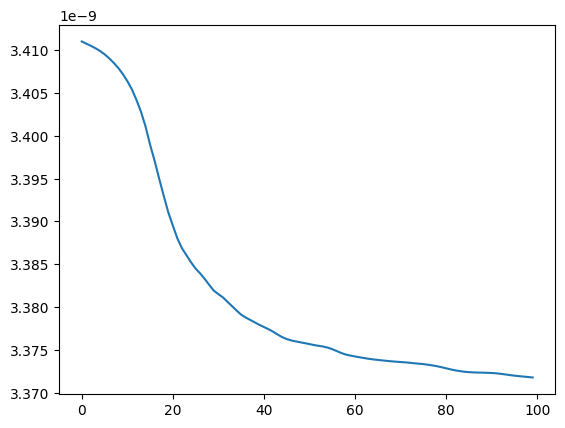

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.4924585617634204e-09, GW-cost: 1.4343415126891464e-15, Total cost: 3.4924585617634204e-09
Final Wasserstein cost: 3.4360899884199403e-09, GW-cost: 1.4302216276576798e-15, Total cost: 3.4360899884199403e-09


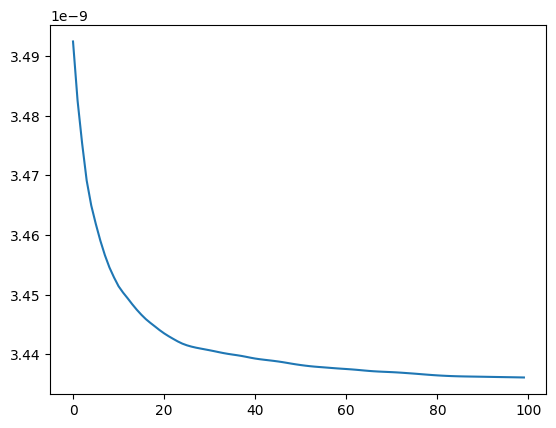

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.94432806873028e-09, GW-cost: 1.2283375449854489e-15, Total cost: 2.94432806873028e-09
Final Wasserstein cost: 2.853762833657549e-09, GW-cost: 1.2237207844883527e-15, Total cost: 2.853762833657549e-09


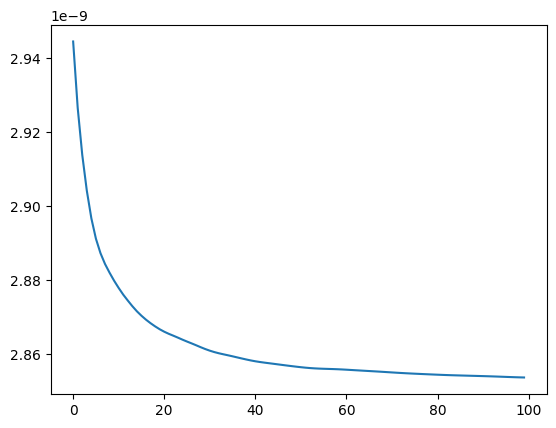

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.858991487013077e-09, GW-cost: 9.103908439785281e-16, Total cost: 2.858991487013077e-09
Final Wasserstein cost: 2.7463266699540264e-09, GW-cost: 8.924155486437343e-16, Total cost: 2.7463266699540264e-09


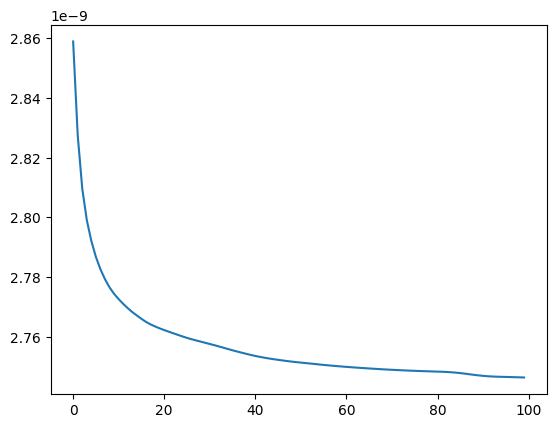

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.638542261879851e-09, GW-cost: 7.547262818481103e-16, Total cost: 2.638542261879851e-09
Final Wasserstein cost: 2.2362994025709936e-09, GW-cost: 6.893585498521283e-16, Total cost: 2.2362994025709936e-09


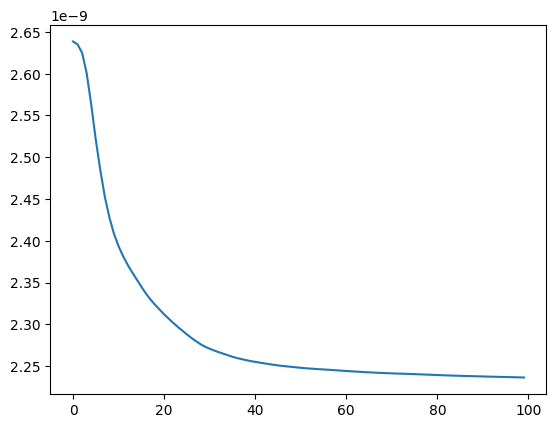

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.8542209930144833e-09, GW-cost: 9.08439942086451e-16, Total cost: 2.8542209930144833e-09
Final Wasserstein cost: 2.7078434348159694e-09, GW-cost: 8.506341636886223e-16, Total cost: 2.7078434348159694e-09


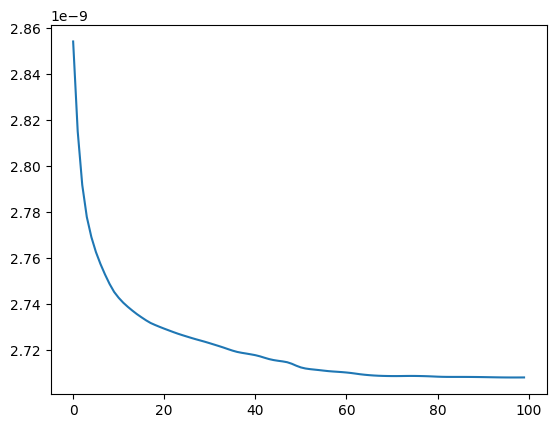

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.9036095341641168e-09, GW-cost: 1.2278853194404704e-15, Total cost: 2.9036095341641168e-09
Final Wasserstein cost: 2.781899540339012e-09, GW-cost: 1.1564255206123487e-15, Total cost: 2.781899540339012e-09


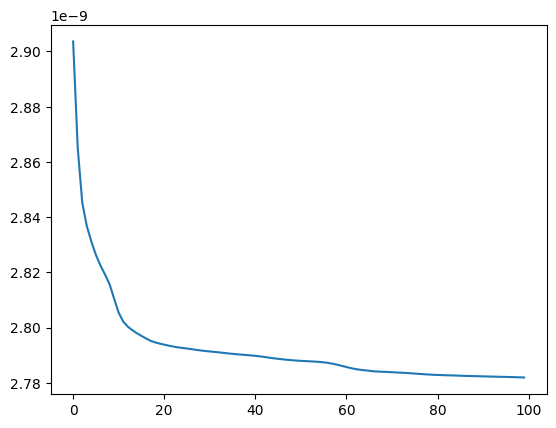

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.485087760520318e-09, GW-cost: 1.4246809749650565e-15, Total cost: 3.485087760520318e-09
Final Wasserstein cost: 3.40428529354274e-09, GW-cost: 1.372671434757006e-15, Total cost: 3.40428529354274e-09


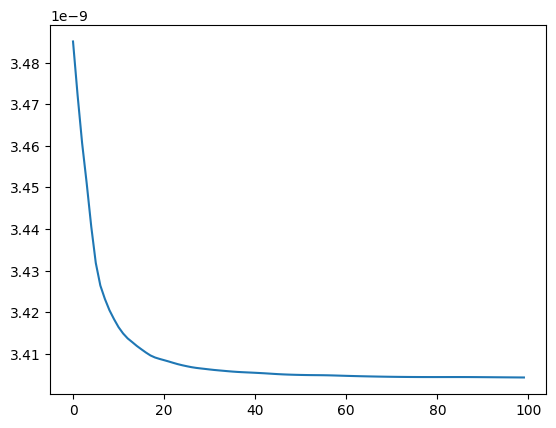

Ranks: r1 3, r2 7, r3 7
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 6.8925254398763195e-09
Final Wasserstein-sum cost: 6.795626884074196e-09


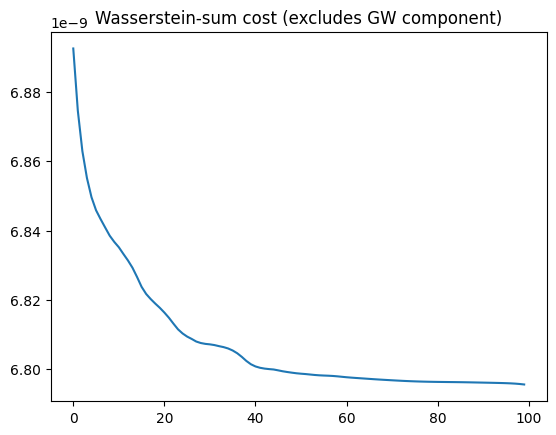

Ranks: r1 7, r2 7, r3 11
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 6.419264070248966e-09
Final Wasserstein-sum cost: 6.234126270167081e-09


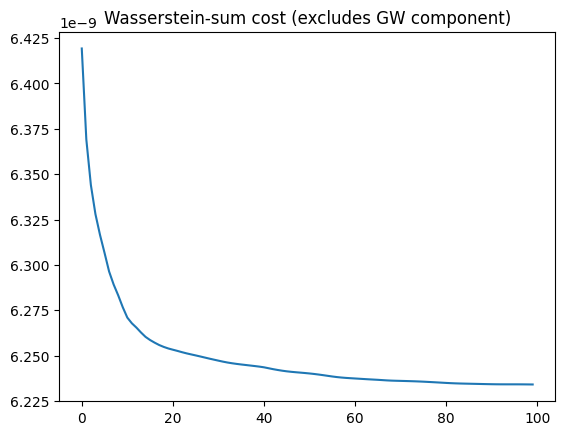

Ranks: r1 7, r2 11, r3 14
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 5.845086961939308e-09
Final Wasserstein-sum cost: 5.599426560827935e-09


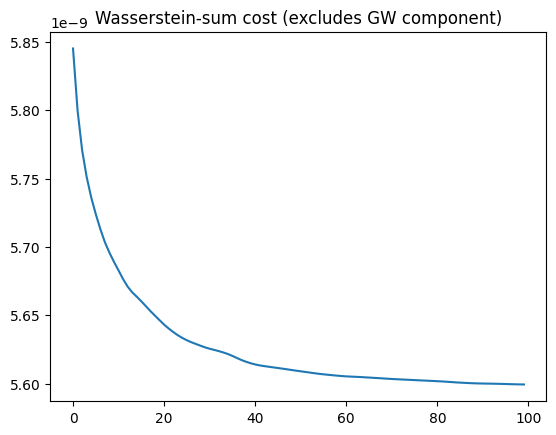

Ranks: r1 11, r2 14, r3 18
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 5.349424904642495e-09
Final Wasserstein-sum cost: 5.012794425615417e-09


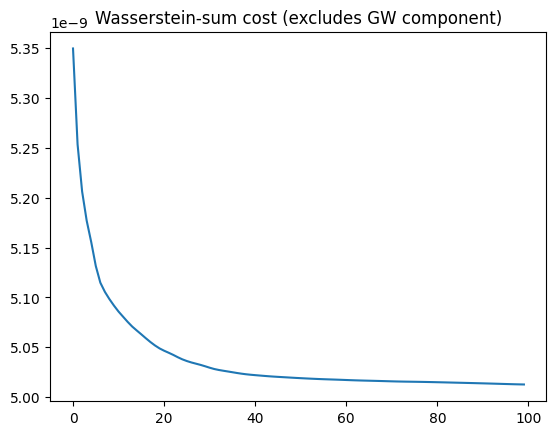

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.397131559152111e-09, GW-cost: 1.1534065315510305e-15, Total cost: 3.397131559152111e-09
Final Wasserstein cost: 3.3858967222285986e-09, GW-cost: 1.1479951247827073e-15, Total cost: 3.3858967222285986e-09


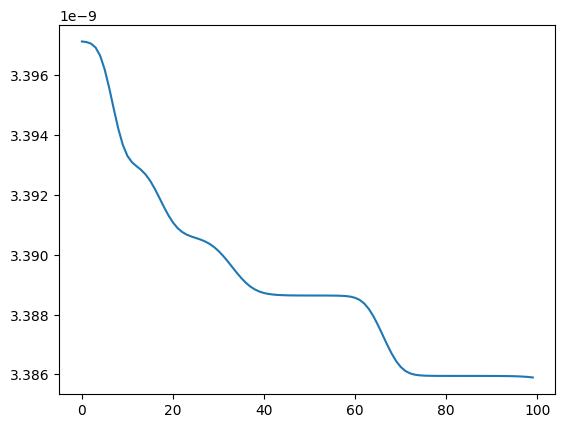

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.4821675668882726e-09, GW-cost: 1.42628721626961e-15, Total cost: 3.4821675668882726e-09
Final Wasserstein cost: 3.4180555538157642e-09, GW-cost: 1.374166951569252e-15, Total cost: 3.4180555538157642e-09


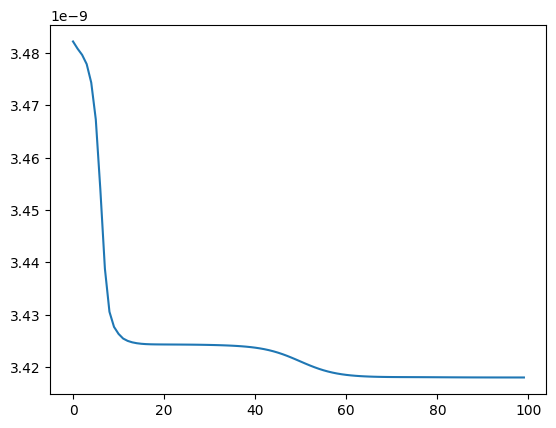

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.9667741617576674e-09, GW-cost: 1.2266074374922176e-15, Total cost: 2.9667741617576674e-09
Final Wasserstein cost: 2.7869008683893486e-09, GW-cost: 1.1591141655996345e-15, Total cost: 2.7869008683893486e-09


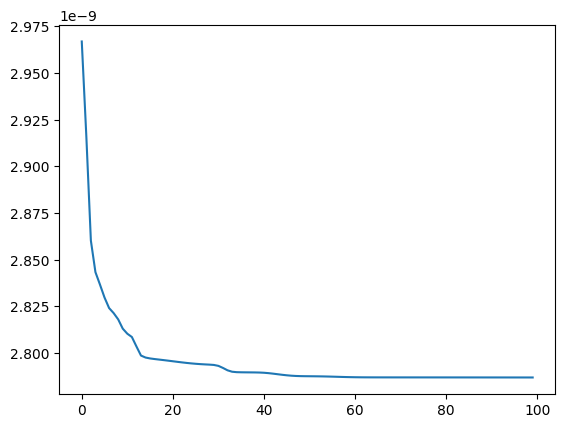

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.8819686626092064e-09, GW-cost: 8.987206513863933e-16, Total cost: 2.8819686626092064e-09
Final Wasserstein cost: 2.7253000994445215e-09, GW-cost: 8.8105610410241185e-16, Total cost: 2.7253000994445215e-09


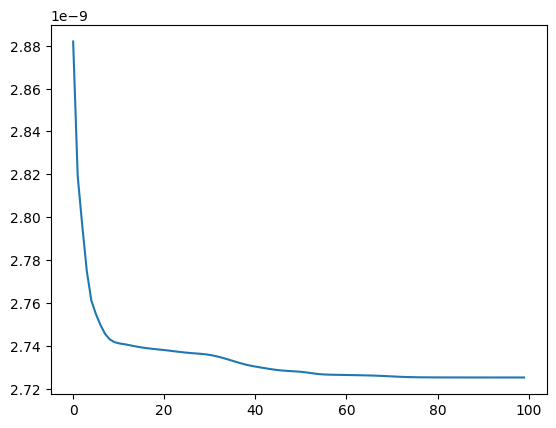

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.5003533019781286e-09, GW-cost: 7.334327909658675e-16, Total cost: 2.5003533019781286e-09
Final Wasserstein cost: 2.2490624157813124e-09, GW-cost: 6.948587266452641e-16, Total cost: 2.2490624157813124e-09


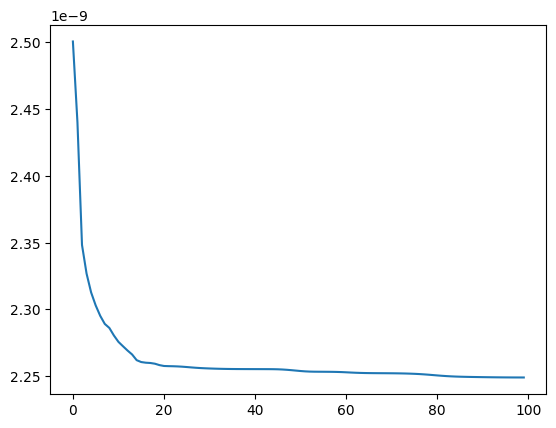

CPU times: user 5min 18s, sys: 3.95 s, total: 5min 22s
Wall time: 5min 18s


In [18]:
%%time
import importlib
import WassersteinDiffMap
importlib.reload(WassersteinDiffMap)


WDM = WassersteinDiffMap.WassersteinDifferentiationMapping(rank_list, tau_in = tau_in, tau_out=tau_out, \
                      gamma=gamma, max_iter=max_iter, min_iter=min_iter, device=device, dtype=torch.float64, \
                     printCost=True, returnFull=False, alpha=alpha, beta=beta, \
                      initialization='Full', init_args = None)

WDM.gamma_smoothing(C_factors_sequence, A_factors_sequence)

Qs_pred = [Q.cpu().numpy() for Q in WDM.Q_gammas]
Ts_pred = [T.cpu().numpy() for T in WDM.T_gammas]

total number of tab colors that can be displayed: 60
total number of unique values: 60


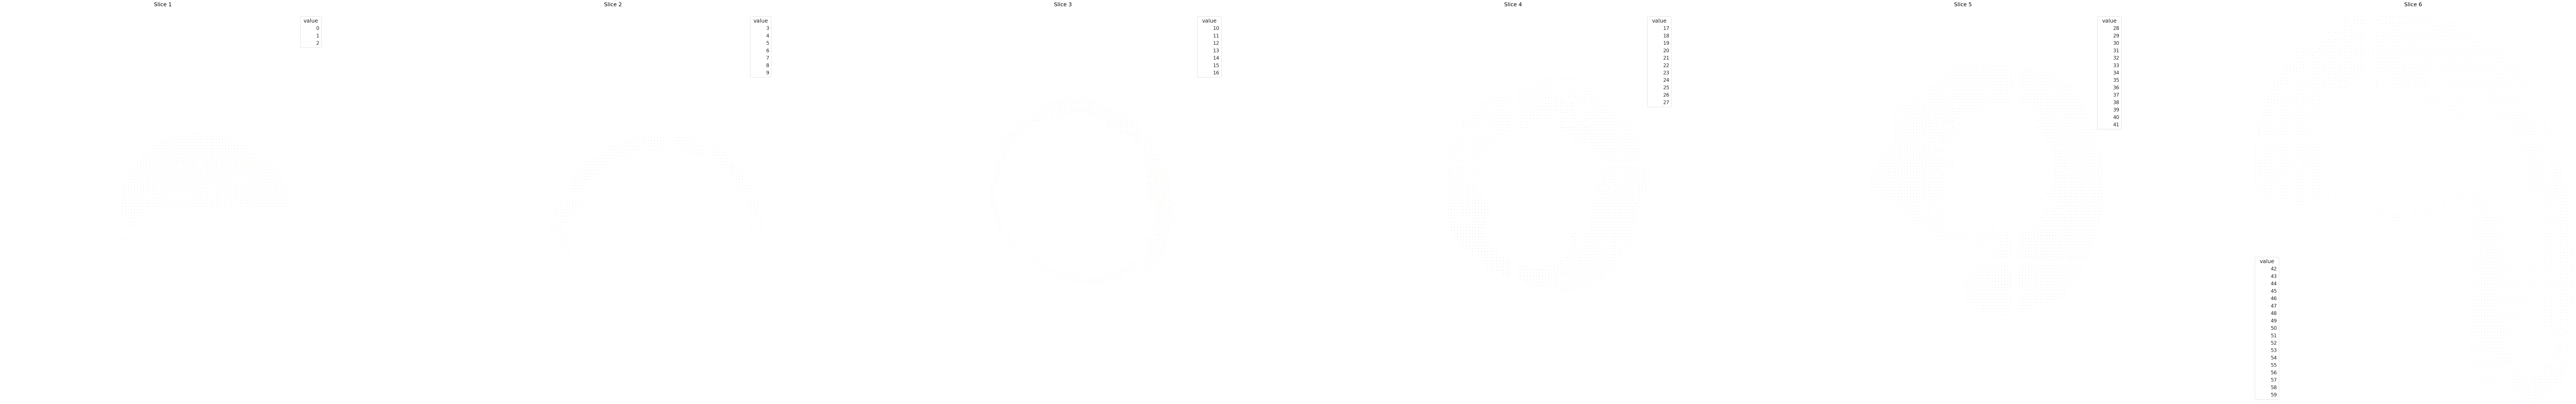

total number of tab colors that can be displayed: 60
total number of unique values: 60


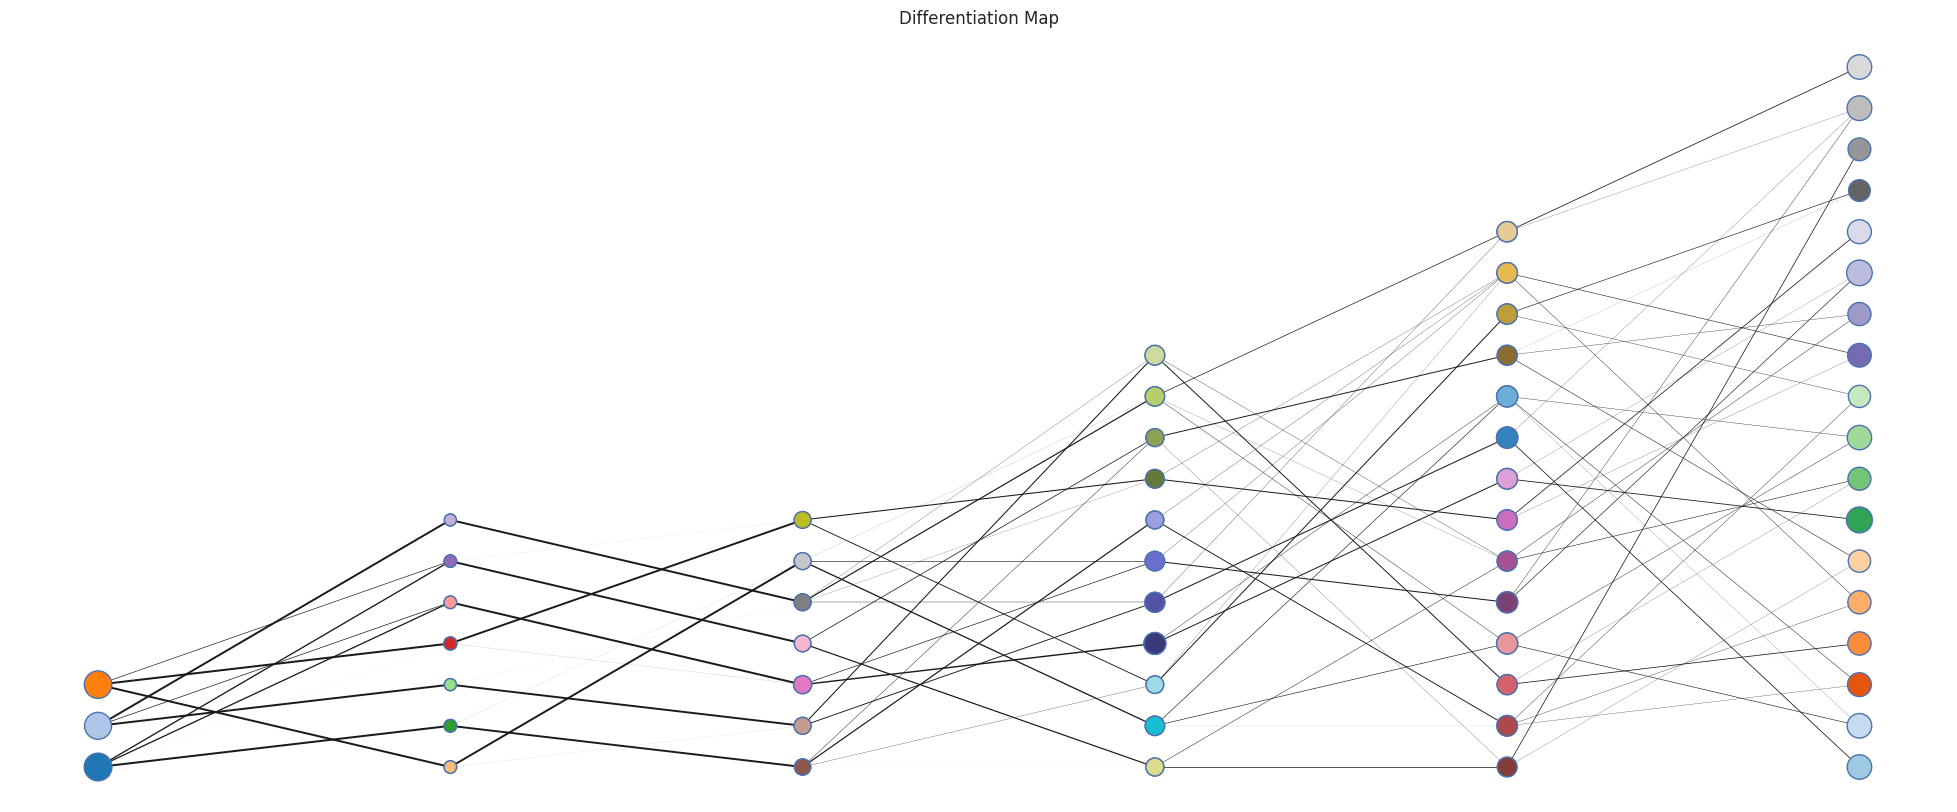

In [19]:
Ss = spatial_list

node_labels1 = [None for Q in WDM.Q_gammas]

clustering.plot_clusters_from_QT(Ss, Qs_pred, Ts_pred, node_labels1)
clustering.diffmap_from_QT(Qs_pred, Ts_pred, cell_type_labels=node_labels1)

## save

In [20]:
for i,Q in enumerate(WDM.Q_gammas):
    np.save(filehandle_save + f'wdm_Q{i}.npy', Q.cpu().numpy())

for i,T in enumerate(WDM.T_gammas):
    np.save(filehandle_save + f'wdm_T{i}{i+1}.npy', T.cpu().numpy())

## ari, ami

In [21]:
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [22]:
gt_types_list = clustering.max_likelihood_clustering(Qs_gt)
pred_types_list = clustering.max_likelihood_clustering(Qs_pred)

util_zf.compute_ARI_and_AMI(gt_types_list, pred_types_list)

ARI and AMI of predictions (filtered excludes ground truth clusters smaller than 5% of the data)

ARI for 0th slice is 0.096 (filtered: 0.096) 	
AMI for 0th slice is 0.108 (filtered: 0.108)


ARI for 1th slice is 0.113 (filtered: 0.119) 	
AMI for 1th slice is 0.190 (filtered: 0.214)


ARI for 2th slice is 0.177 (filtered: 0.185) 	
AMI for 2th slice is 0.212 (filtered: 0.221)


ARI for 3th slice is 0.096 (filtered: 0.090) 	
AMI for 3th slice is 0.200 (filtered: 0.174)


ARI for 4th slice is 0.152 (filtered: 0.146) 	
AMI for 4th slice is 0.296 (filtered: 0.263)


ARI for 5th slice is 0.201 (filtered: 0.206) 	
AMI for 5th slice is 0.451 (filtered: 0.460)




In [23]:
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [24]:
util_zf.silhouette(gt_types_list, pred_types_list, Xs, Ss)

	Pred clusters 0 have **HIGHER** expression silhouette score: 0.012 > 0.008
	Pred clusters 1 have **LOWER** expression silhouette score: 0.000 < 0.008
	Pred clusters 2 have **LOWER** expression silhouette score: 0.013 < 0.015
	Pred clusters 3 have **HIGHER** expression silhouette score: 0.002 > -0.003
	Pred clusters 4 have **HIGHER** expression silhouette score: 0.013 > -0.006
	Pred clusters 5 have **HIGHER** expression silhouette score: 0.015 > -0.021


	Pred clusters 0 have **HIGHER** spatial silhouette score: 0.012 > 0.004
	Pred clusters 1 have **HIGHER** spatial silhouette score: 0.000 > -0.139
	Pred clusters 2 have **LOWER** spatial silhouette score: 0.013 < 0.022
	Pred clusters 3 have **LOWER** spatial silhouette score: 0.002 < 0.059
	Pred clusters 4 have **HIGHER** spatial silhouette score: 0.013 > -0.055
	Pred clusters 5 have **HIGHER** spatial silhouette score: 0.015 > -0.123


In [25]:
util_zf.cos_silhouette(gt_types_list, pred_types_list, Xs, Ss)

	Pred clusters 0 have **HIGHER** expression cosine-silhouette score: 0.019 > 0.011
	Pred clusters 1 have **LOWER** expression cosine-silhouette score: 0.003 < 0.023
	Pred clusters 2 have **HIGHER** expression cosine-silhouette score: 0.056 > 0.056
	Pred clusters 3 have **HIGHER** expression cosine-silhouette score: 0.030 > -0.014
	Pred clusters 4 have **HIGHER** expression cosine-silhouette score: 0.039 > -0.016
	Pred clusters 5 have **HIGHER** expression cosine-silhouette score: 0.030 > -0.047


	Pred clusters 0 have **HIGHER** spatial silhouette score: 0.012 > 0.004
	Pred clusters 1 have **HIGHER** spatial silhouette score: 0.000 > -0.139
	Pred clusters 2 have **LOWER** spatial silhouette score: 0.013 < 0.022
	Pred clusters 3 have **LOWER** spatial silhouette score: 0.002 < 0.059
	Pred clusters 4 have **HIGHER** spatial silhouette score: 0.013 > -0.055
	Pred clusters 5 have **HIGHER** spatial silhouette score: 0.015 > -0.123


## freezing $Q$s with annotations, running `WDM`

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.4066352177605763e-09, GW-cost: 1.1461839768455962e-15, Total cost: 3.4066352177605763e-09
Final Wasserstein cost: 3.3972487093739354e-09, GW-cost: 1.1516559850385266e-15, Total cost: 3.3972487093739354e-09


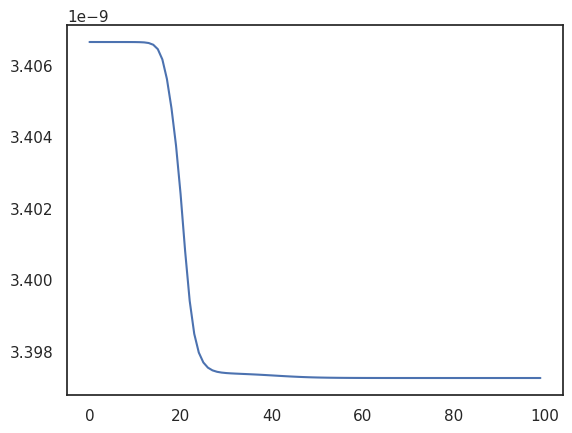

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.4997018982034183e-09, GW-cost: 1.3750699207452579e-15, Total cost: 3.4997018982034183e-09
Final Wasserstein cost: 3.480798307767415e-09, GW-cost: 1.3351952159791927e-15, Total cost: 3.480798307767415e-09


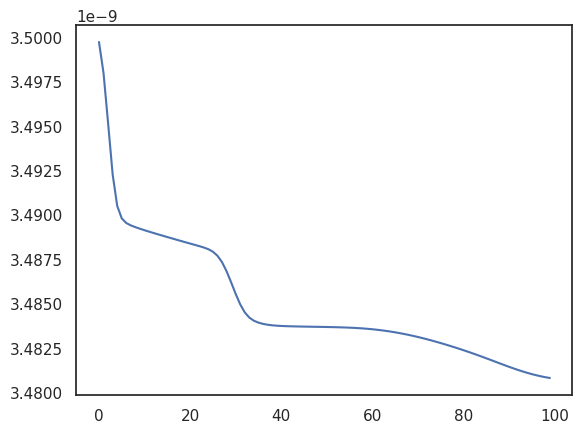

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.004342643535359e-09, GW-cost: 1.1390372278236146e-15, Total cost: 3.004342643535359e-09
Final Wasserstein cost: 2.8597053783221737e-09, GW-cost: 9.623723798586778e-16, Total cost: 2.8597053783221737e-09


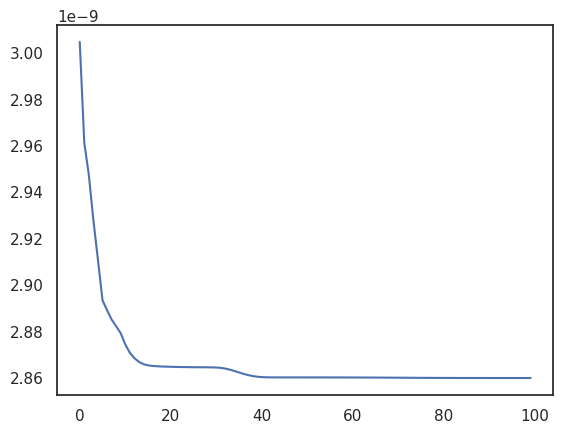

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.9140632054820315e-09, GW-cost: 8.560031507402074e-16, Total cost: 2.9140632054820315e-09
Final Wasserstein cost: 2.8294930725741817e-09, GW-cost: 6.741982947191297e-16, Total cost: 2.8294930725741817e-09


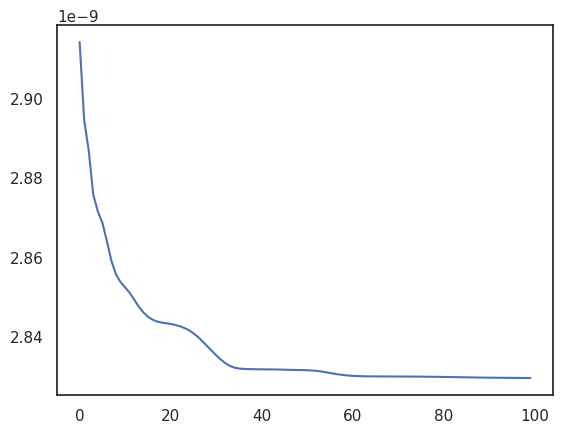

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.575410767608751e-09, GW-cost: 7.21837316960525e-16, Total cost: 2.575410767608751e-09
Final Wasserstein cost: 2.4201181300575013e-09, GW-cost: 6.542150361870431e-16, Total cost: 2.4201181300575013e-09


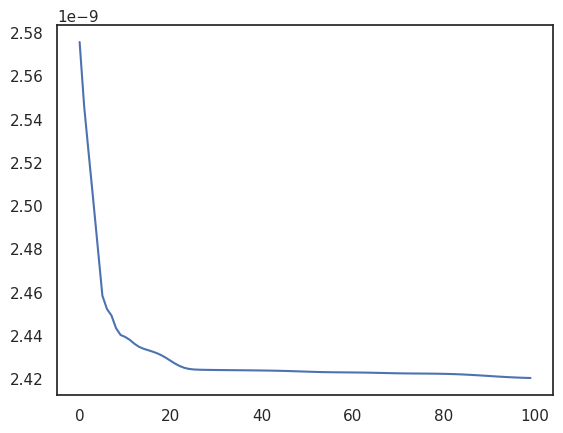

CPU times: user 1min 9s, sys: 1.14 s, total: 1min 10s
Wall time: 1min 8s


In [26]:
%%time
Q_annot = Qs_gt_tensor

importlib.reload(WassersteinDiffMap)

WDM2 = WassersteinDiffMap.WassersteinDifferentiationMapping(ranks, tau_in = tau_in, tau_out=tau_out, \
                      gamma=gamma, max_iter=100, min_iter=100, device=device, dtype=torch.float64, \
                     printCost=True, returnFull=False, alpha=alpha, beta=beta, \
                      initialization='Full', init_args=None)

WDM2.impute_annotated_transitions(C_factors_sequence, A_factors_sequence, Q_annot)
T_gammas = WDM2.T_gammas

In [27]:
for i,Q in enumerate(WDM2.Q_gammas):
    np.save(filehandle_save + f'ann_Q{i}.npy', Q.cpu().numpy())

for i,T in enumerate(WDM2.T_gammas):
    np.save(filehandle_save + f'ann_T{i}{i+1}.npy', T.cpu().numpy())

# Analysis part 1: entropy of transitions

In [28]:
Ts_ann = T_gammas
Ts_pred = Ts_pred

## entropy functions

In [29]:
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [30]:
util_zf.compare_T_entropies(Ts_ann, Ts_pred)
print('\n')
util_zf.compare_T_col_entropies(Ts_ann, Ts_pred)

Pred transitions 0 -> 1 are **MORE** entropic: 2.138 > 1.853
Pred transitions 1 to 2 are **LESS** entropic: 2.031 < 2.400
Pred transitions 2 -> 3 are **MORE** entropic: 2.731 > 2.401
Pred transitions 3 -> 4 are **MORE** entropic: 3.006 > 2.668
Pred transitions 4 -> 5 are **MORE** entropic: 3.325 > 2.998


Pred transitions 0 -> 1 have **MORE** column entropy: 2.138 > 1.061
Pred transitions 1 -> 2 have **LESS** column entropy: 2.031 < 3.340
Pred transitions 2 -> 3 have **MORE** column entropy: 2.731 > 1.797
Pred transitions 3 -> 4 have **LESS** column entropy: 3.006 < 4.331
Pred transitions 4 -> 5 have **LESS** column entropy: 3.325 < 6.287


In [31]:
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [32]:
for i, (T_ann, T_pred) in enumerate(zip(Ts_ann, Ts_pred)):
    T_ann = T_ann.cpu().numpy()
    util_zf.plot_collision_profiles(T_ann, T_pred, title=f'Convergence profiles at slice {i+2}')

TypeError: plot_collision_profiles() got multiple values for argument 'title'

In [ ]:
filehandle_ctd = 'drive/Othercomputers/numac/GitHub/celltypediscovery/'

slice0_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice0_types.npy'))
slice1_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice1_types.npy'))
slice2_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice2_types.npy'))
slice3_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice3_types.npy'))
slice4_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice4_types.npy'))
slice5_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice5_types.npy'))

slice0_set = set(slice0_types)
slice1_set = set(slice1_types)
slice2_set = set(slice2_types)
slice3_set = set(slice3_types)
slice4_set = set(slice4_types)
slice5_set = set(slice5_types)
slice5_set.discard('Otic Vesicle')

print(len(list(slice5_set)))

ct_labels = [ list(slice0_set),
               list(slice1_set),
                list(slice2_set),
                list(slice3_set),
                list(slice4_set),
                list(slice5_set)]

clustering.diffmap_from_QT(Qs_gt, Ts_ann, cell_type_labels=ct_labels)

## what about arg-secondmax? Does this have biological signal?

In [ ]:
labels_2nd = []

for Q in Qs_pred:
    # Get the indices of the sorted entries for each row
    sorted_indices = np.argsort(Q, axis=1)

    # Extract the second-to-last index (the second largest) from the sorted indices
    second_largest_indices = sorted_indices[:, -2]
    labels_2nd += [second_largest_indices]

In [ ]:
threshold = 0.1  # Example threshold as a percentage of the largest value

labels_consensus = []

for Q in Qs_pred:
    argmax_labels = np.argmax(Q, axis=1)
    sorted_indices = np.argsort(Q, axis=1)
    second_argmax_labels = sorted_indices[:, -2]

    # Get the largest and second largest values from Q
    largest_values = np.max(Q, axis=1)
    second_largest_values = Q[np.arange(Q.shape[0]), second_argmax_labels]

    # Apply the threshold to choose between argmax and second argmax
    consensus_labels = np.where((largest_values - second_largest_values) / largest_values < threshold,
                                second_argmax_labels, argmax_labels)

    # Convert consensus_labels (NumPy array) to a regular Python list of ints
    labels = consensus_labels.tolist()  # Convert the array to a list
    labels = [int(label) for label in labels]  # Ensure all elements are ints
    labels = np.array(labels)
    labels_consensus.append(labels)  # Use append to add the new list of labels

# Now labels_consensus is a list of lists, suitable for plotting
clustering.plot_clustering_list(Ss, labels_consensus)

In [ ]:
from scipy.special import softmax

def sample_random_labeling(Q, T=1.0, epsilon=1e-12):
    # Step 1: Normalize Q row-wise to make it row-stochastic
    row_sums = Q.sum(axis=1, keepdims=True)
    P = Q / row_sums

    # Handle division by zero in case row sums are zero
    P = np.nan_to_num(P)

    # Step 2: Take the logarithm of each element (add epsilon to avoid log(0))
    L = np.log(P + epsilon)

    # Step 3: Apply the built-in softmax function with temperature scaling
    # Adjust the input by dividing by the temperature T
    S = softmax(L / T, axis=1)

    # Step 4: Sample a label for each row based on the probabilities in S
    num_rows, num_cols = S.shape
    random_labels = np.array([
        np.random.choice(num_cols, p=S[i])
        for i in range(num_rows)
    ])

    return random_labels

In [ ]:
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as ari

def get_ARI_and_AMI(gt_types_list, pred_types_list, x_percent=5):
    #print(f"ARI and AMI of predictions (filtered excludes ground truth clusters smaller than {x_percent}% of the data)\n")
    aris = []
    amis = []
    for i, (gt_types, pred_types) in enumerate(zip(gt_types_list, pred_types_list)):
        raw_ari = ari(gt_types, pred_types)
        raw_ami = ami(gt_types, pred_types)

        gt_labels = np.array(gt_types)
        pred_labels = np.array(pred_types)
        total_points = len(gt_labels)

        # Compute counts of ground truth clusters
        unique_labels, counts = np.unique(gt_labels, return_counts=True)
        percentages = counts / total_points * 100

        # Identify clusters to keep (clusters with size >= x%)
        clusters_to_keep = unique_labels[percentages >= x_percent]

        # Create a mask to keep only data points in clusters_to_keep
        mask = np.isin(gt_labels, clusters_to_keep)

        # Apply mask to both gt_labels and pred_labels
        gt_labels_filtered = gt_labels[mask]
        pred_labels_filtered = pred_labels[mask]

        # Compute ARI and AMI on the filtered labels
        x_ari = ari(gt_labels_filtered, pred_labels_filtered)
        x_ami = ami(gt_labels_filtered, pred_labels_filtered)

        aris += [x_ari]
        amis += [x_ami]

    return aris, amis

        #print(f'ARI for {i}th slice is {raw_ari:.3f} (filtered: {x_ari:.3f}) \t')
        #print(f'AMI for {i}th slice is {raw_ami:.3f} (filtered: {x_ami:.3f})')
        #print('\n')

In [ ]:
N_samples = 50

n_timepoints = len(Qs_pred)

scores = np.zeros((N_samples, n_timepoints, 2))


#for i in range(N_samples):


'''
for i in range(N_samples):

    labels_sampled = []

    for t, Q in enumerate(Qs_pred):
        random_labels = sample_random_labeling(Q, T=1e-3)
        labels_sampled.append(random_labels)  # Use append to add the new list of labels

    aris, amis = get_ARI_and_AMI(gt_types_list, labels_sampled)
    aris_inner_np = [ np.array(ari) for ari in aris ]
    amis_inner_np = [ np.array(ami) for ami in amis ]

    aris_np = np.array(aris_inner_np)
    amis_np = np.array(amis_inner_np)

    scores[i, :, 0] = aris_np
    scores[i, :, 1] = amis_np
''';

In [ ]:
print(np.mean(scores[:,:,0], axis=0))

In [ ]:
print(np.max(scores[:,:,0], axis=0))

# Analysis part 2: DE analysis

## load output of `WDM`

In [ ]:
wdm_Qs = []
wdm_Ts = []


wdm_Q0 = np.load(filehandle_save + 'wdm_Q0.npy')
wdm_Q1 = np.load(filehandle_save + 'wdm_Q1.npy')
wdm_Q2 = np.load(filehandle_save + 'wdm_Q2.npy')

wdm_T0 = np.load(filehandle_save + 'wdm_T0.npy')
wdm_T1 = np.load(filehandle_save + 'wdm_T1.npy')

ann_Q0 = np.load(filehandle_save+ 'ann_Q0.npy')

ann_Q1 = np.load(filehandle_save + 'ann_Q1.npy')
ann_Q1_imp = np.load(filehandle_save + 'ann_Q1_imp.npy')

ann_Q2 = np.load(filehandle_save + 'ann_Q2.npy')

ann_T0_imp = np.load(filehandle_save + 'ann_T0_imp.npy')
ann_T1_imp = np.load(filehandle_save + 'ann_T1_imp.npy')

ann_T0 = np.load(filehandle_save + 'ann_T0.npy')
ann_T1 = np.load(filehandle_save + 'ann_T1.npy')

### lists of these for the three cases

Qs_ann = [ann_Q0, ann_Q1, ann_Q2]
Ts_ann = [ann_T0, ann_T1]

Qs_ann_imp = [ann_Q0, ann_Q1_imp, ann_Q2]
Ts_ann_imp = [ann_T0_imp, ann_T1_imp]

Qs_wdm = [wdm_Q0, wdm_Q1, wdm_Q2]
Ts_wdm = [wdm_T0, wdm_T1]

## set ranks, set `i` = first timepoint of three: `i`, `i+1`, `i+2`

In [ ]:
ranks = [(3,7),(7,7),(7,11),(11,14),(14,19)]

i=2

r1, r2 = ranks[i]
r2, r3 = ranks[i+1]

## load features and spatial coords specific to the triple

In [ ]:
s0_name = zf_names[i]
s1_name = zf_names[i+1]
s2_name = zf_names[i+2]

filehandle_pair1 = filehandle_zf + 'pair' + str(i) + '/'
filehandle_pair2 = filehandle_zf + 'pair' + str(i+1) + '/'

X0 = np.load(filehandle_pair1 + s0_name + '_feature.npy')
X1 = np.load(filehandle_pair1 + s1_name + '_feature.npy')
X2 = np.load(filehandle_pair2 + s2_name + '_feature.npy')

S0 = spatial_list[i]
S1 = spatial_list[i+1]
S2 = spatial_list[i+2]

Ss = [S0, S1, S2]

## load labels

In [ ]:
filehandle_ctd = 'drive/Othercomputers/numac/GitHub/celltypediscovery/'

slice0_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice0_types.npy'))
slice1_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice1_types.npy'))
slice2_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice2_types.npy'))
slice3_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice3_types.npy'))
slice4_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice4_types.npy'))
slice5_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice5_types.npy'))

ct_labels = [ list(set(slice0_types)),
               list(set(slice1_types)),
                list(set(slice2_types)),
                list(set(slice3_types)),
                list(set(slice4_types)),
                list(set(slice5_types))]

target_value = 'Otic Vesicle'
# Find indices where the elements match the target value
indices = [index for index, value in enumerate(slice5_types) if value == 'Otic Vesicle']

print(f"Indices of '{target_value}' in the list: {indices}")

## case 1: `ml` clustering,  annotations

In [ ]:
type(slice5_types)

In [ ]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_ann,
                        Ts=Ts_ann,
                        cell_type_labels=cell_type_labels_case_1,
                        clustering_type='ml')

## case 2: `ml` clustering, annotations at $t_1, t_3$

In [ ]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_ann_imp,
                        Ts=Ts_ann_imp,
                        cell_type_labels=cell_type_labels_case_2,
                        clustering_type='ml')

## case 3: fully unsupervised

In [ ]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_wdm,
                        Ts=Ts_wdm,
                        cell_type_labels=cell_type_labels_case_3,
                        clustering_type='ml')

## focus on case 3, what does differential expression reveal about how these clusters compare to the annotations?

In [ ]:
pred_clustering_list = clustering.max_likelihood_clustering(Qs_wdm)
gt_clustering_list = clustering.max_likelihood_clustering(Qs_gt[2:5])

In [ ]:
pred_clustering_0 = pred_clustering_list[0]
pred_clustering_1 = pred_clustering_list[1]
pred_clustering_2 = pred_clustering_list[2]

## differential expression at 10hpf:

In [ ]:
_adata0 = adatas[2].copy()

_adata0.obs['diff_map_cluster'] = pred_clustering_0
_adata0.obs['diff_map_cluster'] = _adata0.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(_adata0)
sc.pp.log1p(_adata0)

# Differential gene expression analysis
sc.tl.rank_genes_groups(_adata0, groupby='diff_map_cluster', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata0, n_genes=10, sharey=False, key = "t-test")

# Bin-annotation
sc.tl.rank_genes_groups(_adata0, groupby='bin_annotation', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata0, n_genes=10, sharey=False, key = "t-test")


## most interesting predicted clusters at 10hpf

## differential expression at 12hpf:

In [ ]:
_adata1 = adatas[3].copy()

_adata1.obs['diff_map_cluster'] = pred_clustering_1
_adata1.obs['diff_map_cluster'] = _adata1.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(_adata1)
sc.pp.log1p(_adata1)

# Differential gene expression analysis
sc.tl.rank_genes_groups(_adata1, groupby='diff_map_cluster', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata1, n_genes=10, sharey=False, key = "t-test")

# Bin-annotation
sc.tl.rank_genes_groups(_adata1, groupby='bin_annotation', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata1, n_genes=10, sharey=False, key = "t-test")


## most interesting predicted clusters at 12hpf

## differential expression at 18hpf:

In [ ]:
_adata2 = adatas[4].copy()

_adata2.obs['diff_map_cluster'] = pred_clustering_2
_adata2.obs['diff_map_cluster'] = _adata2.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(_adata2)
sc.pp.log1p(_adata2)

# Differential gene expression analysis
sc.tl.rank_genes_groups(_adata2, groupby='diff_map_cluster', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata2, n_genes=10, sharey=False, key = "t-test")

# Bin-annotation
sc.tl.rank_genes_groups(_adata2, groupby='bin_annotation', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata2, n_genes=10, sharey=False, key = "t-test")


## most interesting predicted clusters at 18hpf